In [98]:
import json
from collections import defaultdict

cnt = 0
original = 0
tweets = {} # tweet 内容
tweets_url = {} # tweets 对应的url
url_tweetid = defaultdict(list) # url对应的tweets

# 载入原始数据
for line in open("data/tweets_fake.txt"):
    d = json.loads(line)
    if "final_url" in d:            
        tweets[d["tweet_id"]] = d
        cnt += 1
        if d["retweeted_status"] == 1:
            original += 1

        url = d["final_url"].lower()
        tweets_url[d["tweet_id"]] = url
        url_tweetid[url].append({"id": d["tweet_id"], "dt": d["datetime_EST"]})
            
# with open("data/tweets_fake.txt", "w") as f:        
#     for v in tweets.values():
#         f.write(json.dumps(v, ensure_ascii=False) + "\n")
    

In [99]:
print(cnt)
print("存在url的tweet：", len(tweets))
print("原创tweet：", original)
print("url集合的量：", len(url_tweetid))

2338079
存在url的tweet： 2338079
原创tweet： 209143
url集合的量： 189621


In [163]:
import sqlite3

def find_tweet(_id):
    conn1 = sqlite3.connect("/home/alex/network_workdir/elections/databases_ssd/complete_trump_vs_hillary_db.sqlite")
    conn2 = sqlite3.connect("/home/alex/network_workdir/elections/databases_ssd/complete_trump_vs_hillary_sep-nov_db.sqlite")
    c1 = conn1.cursor()
    c2 = conn2.cursor()

    new_d = {}
    c1.execute('''SELECT * FROM tweet WHERE tweet_id={}'''.format(_id))
    d = c1.fetchone()
    if d:
        col_name = [t[0] for t in c1.description]
            # print(d)
        for k, v in zip(col_name, d):
            new_d[k] = v

    else:
        c2.execute('''SELECT * FROM tweet WHERE tweet_id={}'''.format(_id))
        d = c2.fetchone()
        if d:
            col_name = [t[0] for t in c1.description]
            # print(d)
            for k, v in zip(col_name, d):
                new_d[k] = v
    
    conn1.close()
    conn2.close()
    
    if not new_d:
        new_d = find_retweeted(_id)
        
    if not new_d:
        print("找不到该tweet：", _id)
        
    return new_d


def find_original_tweetid(_id):
    conn1 = sqlite3.connect("/home/alex/network_workdir/elections/databases_ssd/complete_trump_vs_hillary_db.sqlite")
    conn2 = sqlite3.connect("/home/alex/network_workdir/elections/databases_ssd/complete_trump_vs_hillary_sep-nov_db.sqlite")
    c1 = conn1.cursor()
    c2 = conn2.cursor()

    new_d = {}
    c1.execute('''SELECT * FROM tweet_to_retweeted_uid WHERE tweet_id={}'''.format(_id))
    d = c1.fetchone()
    if d:
        col_name = [t[0] for t in c1.description]
            # print(d)
        for k, v in zip(col_name, d):
            new_d[k] = v

    else:
        c2.execute('''SELECT * FROM tweet_to_retweeted_uid WHERE tweet_id={}'''.format(_id))
        d = c2.fetchone()
        if d:
            col_name = [t[0] for t in c1.description]
            # print(d)
            for k, v in zip(col_name, d):
                new_d[k] = v
        else:
            print("没有转发关系！", _id)
            
    conn1.close()
    conn2.close()

    return new_d   


def find_retweeted(_id):
    conn1 = sqlite3.connect("/home/alex/network_workdir/elections/databases_ssd/complete_trump_vs_hillary_db.sqlite")
    conn2 = sqlite3.connect("/home/alex/network_workdir/elections/databases_ssd/complete_trump_vs_hillary_sep-nov_db.sqlite")
    c1 = conn1.cursor()
    c2 = conn2.cursor()

    new_d = {}
    c1.execute('''SELECT * FROM retweeted_status WHERE tweet_id={}'''.format(_id))
    d = c1.fetchone()
    if d:
        col_name = [t[0] for t in c1.description]
            # print(d)
        for k, v in zip(col_name, d):
            new_d[k] = v

    else:
        c2.execute('''SELECT * FROM retweeted_status WHERE tweet_id={}'''.format(_id))
        d = c2.fetchone()
        if d:
            col_name = [t[0] for t in c1.description]
            # print(d)
            for k, v in zip(col_name, d):
                new_d[k] = v
        else:
            print("没有找到原创tweet", _id)
            
    conn1.close()
    conn2.close()

    return new_d

In [100]:
# 利用转发网络扩充谣言数据

fake_retweets_links = json.load(open("data/retweet_network_fake.json"))
fake_tweets = set()

for k, v in fake_retweets_links.items():
    fake_tweets.add(k)
    fake_tweets.add(v)
    
    # 如果原始tweet不是fake news，不考虑
    if str(v) not in tweets_url:
        continue
        
    original_url = tweets_url[str(v)]
    if str(k) in tweets:
        url_tweetid[original_url].append(tweets[str(k)])
    else:
        url_tweetid[original_url].append(find_tweet(_id))
    
print("fake spread的节点个数：", len(fake_tweets))

fake spread的节点个数： 1930939


In [102]:
import pandas as pd

data = pd.Series([len(v) for v in url_tweetid.values()])
data.describe()

count    189621.000000
mean         12.330275
std          82.532005
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max       10599.000000
dtype: float64

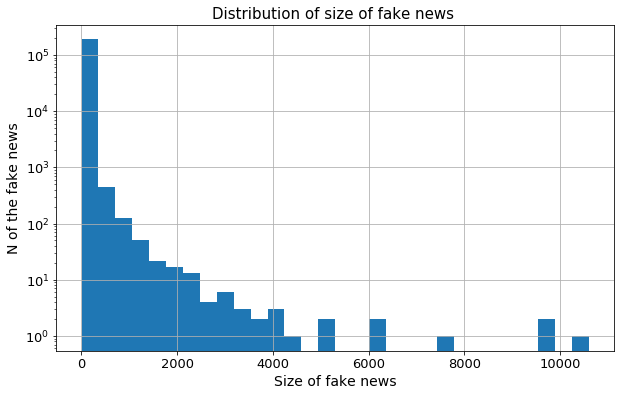

In [156]:
import numpy as np
import matplotlib.pyplot as plt

def get_cdf_pdf(data, mini, maxi, step, norm=True):
    x = [float(i) for i in np.arange(mini, maxi, step)]
    cdf = [0] * len(x)
    pdf = [0] * len(x)
    count = 0
    for d in data:
        d = float(d)
        if d < mini or d > maxi:
            continue
        count += 1
        for i in range(len(x)):
            if i == (len(x) - 1) and d >= x[i]:
                pdf[i] += 1
            elif d >= x[i] and d < x[i+1]:
                pdf[i] += 1

            if d >= x[i]:
                cdf[i] += 1

    if norm:
        cdf = [c / count for c in cdf]
        pdf = [p / count for p in pdf]

    return x, cdf, pdf


x, cdf, pdf = get_cdf_pdf(data, 0, 11000, 100)
plt.figure(figsize=(10, 6))
data[data<11000].hist(bins=30)
plt.title('Distribution of size of fake news ', fontsize=15)
plt.ylabel('N of the fake news', fontsize=14)
plt.xlabel('Size of fake news', fontsize=14)
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.yscale("log")
plt.savefig('fig/distribution_size_fake_news.pdf'.format(i, url), dpi=300)
plt.show()
plt.close()


In [106]:
url_tweetid["https://thepoliticalinsider.com/clinton-foundation-obama-made-major-move-keep-prison-leaked/"]

[{'id': 763804618547572736, 'dt': '2016-08-11 13:29:46'},
 {'id': 763804883212505088, 'dt': '2016-08-11 13:30:49'},
 {'id': 763993324285861893, 'dt': '2016-08-12 01:59:37'},
 {'id': 764000152042414084, 'dt': '2016-08-12 02:26:45'},
 {'id': 764028274485829633, 'dt': '2016-08-12 04:18:30'},
 {'id': 764051322282782721, 'dt': '2016-08-12 05:50:05'},
 {'id': 764055110414536704, 'dt': '2016-08-12 06:05:08'},
 {'id': 765316378341482496, 'dt': '2016-08-15 17:36:58'},
 {'id': 765643842888437760, 'dt': '2016-08-16 15:18:11'}]

In [107]:
# save

json.dump(url_tweetid, open("data/data_url_combining.txt", "w"), indent=2)

In [109]:
import pendulum

url_tweetid = json.load(open("data/data_url_combining.txt"))

In [248]:
# 先按照每个谣言涉及到的tweet数量进行排序

sorted_url = sorted(url_tweetid.items(), key=lambda d: len(d[1]), reverse=True)

for i, v in enumerate(sorted_url):
    if len(v[1]) > 1:
        print(i, len(v[1]), v[0], sep="\t", file=open("data/id_len_url.txt", "a"))

In [249]:
import matplotlib.pyplot as plt
import pandas as pd
from urllib.parse import urlparse


def covert_timeseries(i, url, sorted_dts):
    
    print("实际传播开始和结束时间：", sorted_dts[0], sorted_dts[-1])
    
    start = get_day(sorted_dts[0])
    end = get_day(sorted_dts[-1])
    print(start, end)
    rng = pd.date_range(start, end, freq='H')
    
    ts = pd.Series(0, rng)
    
#     print(ts)
    for dt in sorted_dts:
        now = get_day(dt)
        ts[now] += 1
#     print(ts)

    plt.figure(figsize=(10, 6))
    ts.plot()
#     plt.xlabel('$Date$', fontsize=15)
    plt.title(url)
    plt.ylabel('N of tweets with this fake news', fontsize=15)
    plt.xticks(fontsize=11); plt.yticks(fontsize=11)
    plt.savefig('fig/{}-{}-overall-spread.pdf'.format(i, url), dpi=300)
    plt.close()
    #     plt.show()


def plot_firstday(i, url, sorted_dts):
    
    start = get_hour(sorted_dts[0])
    rng = pd.date_range(start, periods=48, freq='H')
    
    ts = pd.Series(0, rng)
    
#     print(ts)
    for dt in sorted_dts:
        now = get_hour(dt)
        if now in ts:
            ts[now] += 1
            
    plt.figure(figsize=(10, 6))
    ts.plot()
#     plt.xlabel('$Date$', fontsize=15)
    plt.title(url)
    plt.ylabel('N of tweets with this fake news', fontsize=15)
    plt.xticks(fontsize=11); plt.yticks(fontsize=11)
    plt.savefig('fig/{}-{}-first-48-hours.pdf'.format(i, url), dpi=300)
    plt.close()
#     plt.show()
    

def get_day(dt):
    return pendulum.parse(dt).format("YYYY-MM-DD 00:00:00")
    
    
def get_hour(dt):
    return pendulum.parse(dt).format("YYYY-MM-DD HH:00:00")
    
    
for i, values in enumerate(sorted_url):
    if i == 100:
        break
        
    print("ploting", i, "...")
    
    dts = sorted([v["dt"] for v in values[1]])
    url = urlparse(values[0]).hostname
    covert_timeseries(i, url, dts)
    plot_firstday(i, url, dts)
    

ploting 0 ...
实际传播开始和结束时间： 2016-04-29 10:51:25 2016-11-09 23:56:49
2016-04-29 00:00:00 2016-11-09 00:00:00
ploting 1 ...
实际传播开始和结束时间： 2016-06-13 12:57:36 2016-11-09 08:50:45
2016-06-13 00:00:00 2016-11-09 00:00:00
ploting 2 ...
实际传播开始和结束时间： 2016-11-04 07:59:46 2016-11-09 20:21:45
2016-11-04 00:00:00 2016-11-09 00:00:00
ploting 3 ...
实际传播开始和结束时间： 2016-07-31 16:08:39 2016-11-07 21:25:39
2016-07-31 00:00:00 2016-11-07 00:00:00
ploting 4 ...
实际传播开始和结束时间： 2016-09-30 11:12:25 2016-11-07 01:52:41
2016-09-30 00:00:00 2016-11-07 00:00:00
ploting 5 ...
实际传播开始和结束时间： 2016-10-02 15:46:18 2016-11-09 07:30:01
2016-10-02 00:00:00 2016-11-09 00:00:00
ploting 6 ...
实际传播开始和结束时间： 2016-10-28 10:25:02 2016-11-08 15:30:27
2016-10-28 00:00:00 2016-11-08 00:00:00
ploting 7 ...
实际传播开始和结束时间： 2016-10-25 06:15:40 2016-11-08 14:05:30
2016-10-25 00:00:00 2016-11-08 00:00:00
ploting 8 ...
实际传播开始和结束时间： 2016-10-13 15:17:28 2016-11-06 08:10:29
2016-10-13 00:00:00 2016-11-06 00:00:00
ploting 9 ...
实际传播开始和结束时间： 2016-10-14

In [146]:
def find_the_first(_tweets):
    tid = 0
    count = 0
    dt = pendulum.parse("2019-01-01")
    for t in _tweets:
        now_dt = pendulum.parse(t["dt"])
        if now_dt < dt:
            tid = t["id"]
            dt = now_dt
    return {"tweet_id": tid, "dt": dt.for_json()}

url_first = {}
for k, v in sorted_url:
    new_d = find_the_first(v)
    new_d.update(tweets[new_d["tweet_id"]])
    new_d["tweets_count"] = len(v)
    url_first[k] = new_d

for i, v in enumerate(url_first):
    if i < 10:
        print(i, v, url_first[v])

0 http://infowars.com/show {'tweet_id': 726076431411761152, 'dt': '2016-04-29T10:51:25+00:00', 'datetime_EST': '2016-04-29 10:51:25', 'user_id': 733838438, 'url': 'http://infowars.com/show', 'indice_start': 78, 'source_content': 'Sprout Social', 'retweeted_status': 1, 'final_url': 'http://infowars.com/show', 'final_hostname': 'infowars.com', 'tweets_count': 10599}
1 http://www.zerohedge.com/news/2016-06-13/saudi-arabia-has-funded-20-hillarys-presidential-campaign-saudi-crown-prince-claims {'tweet_id': 742415639982313472, 'dt': '2016-06-13T12:57:36+00:00', 'datetime_EST': '2016-06-13 12:57:36', 'user_id': 18856867, 'url': 'http://www.zerohedge.com/news/2016-06-13/saudi-arabia-has-funded-20-hillarys-presidential-campaign-saudi-crown-prince-claims', 'indice_start': 90, 'source_content': 'Zero Hedge Publisher II', 'retweeted_status': 1, 'final_url': 'http://www.zerohedge.com/news/2016-06-13/saudi-arabia-has-funded-20-hillarys-presidential-campaign-saudi-crown-prince-claims', 'final_hostnam

In [125]:
json.dump(url_first, open("data/data_url_first.txt", "w"), indent=2)

我发现很多starter居然是转发后的tweet（132,823），并不是原创的（56,798）！这样我就需要检查一下，那转发前的tweet，是不包括fake news还是说它本身并没有被获取到

In [194]:
for i, (k, v) in enumerate(url_first.items()):
    if i > 5:
        break
    print(find_tweet(v["tweet_id"]))

{'tweet_id': 726076431411761152, 'query_id': 1, 'filename_id': 521, 'datetime_EST': '2016-04-29 10:51:25', 'user_id': 733838438, 'text': "Here's why we need Trump's wall... we're losing #freespeech LIVE 11am-3pm CST https://t.co/9sM9dTv64a #tcot #trump https://t.co/FfaJTHkYkT", 'place': None, 'source_url_id': 72, 'source_content_id': 75}
{'tweet_id': 742415639982313472, 'query_id': 0, 'filename_id': 53, 'datetime_EST': '2016-06-13 12:57:36', 'user_id': 18856867, 'text': "Saudi Arabia Has Funded 20% Of Hillary's Presidential Campaign, Saudi Crown Prince Claims https://t.co/0aUE5D4xQQ", 'place': None, 'source_url_id': 2078, 'source_content_id': 2276, 'p_pro_hillary_anti_trump': None}
{'tweet_id': 794524538008649728, 'query_id': 0, 'filename_id': 542, 'datetime_EST': '2016-11-04 07:59:46', 'user_id': 18643437, 'text': '“Spirit Cooking”: Clinton Campaign Chairman Invited to Bizarre Satanic Performance - https://t.co/GsPaxPyyUR… https://t.co/axAN00LKv5', 'place': None, 'source_url_id': 3, '

In [193]:
# 分析starter的source

def find_source(_id):
    conn1 = sqlite3.connect("/home/alex/network_workdir/elections/databases_ssd/complete_trump_vs_hillary_db.sqlite")
    conn2 = sqlite3.connect("/home/alex/network_workdir/elections/databases_ssd/complete_trump_vs_hillary_sep-nov_db.sqlite")
    c1 = conn1.cursor()
    c2 = conn2.cursor()

    new_d = {}
    c1.execute('''SELECT * FROM source_content WHERE id={}'''.format(_id))
    d = c1.fetchone()
    if d:
        col_name = [t[0] for t in c1.description]
            # print(d)
        for k, v in zip(col_name, d):
            new_d[k] = v

    else:
        c2.execute('''SELECT * FROM source_content WHERE id={}'''.format(_id))
        d = c2.fetchone()
        if d:
            col_name = [t[0] for t in c1.description]
            # print(d)
            for k, v in zip(col_name, d):
                new_d[k] = v
    
    conn1.close()
    conn2.close()
    
    if not new_d:
        new_d = find_retweeted(_id)
        
    if not new_d:
        print("找不到该source：", _id)
        
    return new_d


from collections import Counter

count = []
for k, v in url_first.items():
    count.append(v["source_content"])
_sum = len(count)
count = Counter(count)

for k, v in count.most_common(20):
    print(k, '- {:.2%}'.format(v / _sum))

Twitter Web Client - 24.52%
dlvr.it - 15.56%
Put your button on any page!  - 13.48%
twitterfeed - 6.14%
Facebook - 5.69%
Twitter for iPhone - 4.23%
Linkis.com - 4.05%
Twitter for Android - 3.25%
Twitter for iPad - 2.26%
Sprout Social - 2.11%
Buffer - 1.65%
WordPress.com - 1.60%
IFTTT - 1.55%
Mobile Web - 1.48%
Hootsuite - 1.24%
Boost your self-promotion! - 1.11%
Put your brand on any website! - 1.00%
Your best free sharing tool! - 0.80%
AboveTopSecret.com New Topics - 0.76%
Turn sharing to content creation - 0.67%


In [205]:
from tqdm import tqdm

stopwords = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])
words = []
loss = 0
for v in tqdm(url_first.values()):
    twi = find_tweet(v["tweet_id"])
    if "text" in twi:
        w = [t.lower() for t in twi["text"].split(" ") if t not in stopwords]
        words.extend(w)
    else:
        loss += 1
print(loss)
words = Counter(words)

100%|██████████| 189621/189621 [02:16<00:00, 1391.88it/s]


0


In [207]:
words.most_common(50)

[('hillary', 66003),
 ('trump', 51894),
 ('clinton', 44643),
 ('the', 25379),
 ('via', 22486),
 ('-', 21709),
 ('to', 20141),
 ('', 17343),
 ('–', 12876),
 ('is', 12147),
 ('in', 10885),
 ('for', 10822),
 (':', 10807),
 ('video', 9961),
 ('hillary’s', 9637),
 ('of', 9614),
 ('donald', 9521),
 ('this', 8866),
 ('fbi', 8339),
 ('just', 8250),
 ('a', 8053),
 ('obama', 7662),
 ('her', 7143),
 ('new', 7112),
 ('will', 6991),
 ('campaign', 6859),
 ('with', 6815),
 ('on', 6773),
 ('about', 6714),
 ('|', 6551),
 ('wikileaks', 6547),
 ('breaking:', 6248),
 ('and', 6096),
 ('@realalexjones', 5863),
 ('media', 5824),
 ('bill', 5636),
 ('#tcot', 5517),
 ('email', 5347),
 ('emails', 5172),
 ('&amp;', 5148),
 ("hillary's", 5105),
 ('clinton’s', 4969),
 ('what', 4958),
 ('says', 4868),
 ('after', 4802),
 ('she', 4709),
 ('breaking', 4554),
 ('election', 4528),
 ('you', 4436),
 ('@realdonaldtrump', 4391)]

In [213]:
# 用户分析

count = []
for k, v in url_first.items():
    count.append(v["user_id"])
_sum = len(count)
count = Counter(count)
count.most_common(20)

[(122455671, 3701),
 (4831603043, 2532),
 (60893069, 2079),
 (4496549793, 1814),
 (825501626, 1689),
 (3274720530, 1686),
 (3374126201, 1567),
 (14210021, 1451),
 (137637040, 1102),
 (18856867, 1085),
 (18208120, 1028),
 (138092553, 916),
 (634330366, 881),
 (112732163, 851),
 (359122436, 781),
 (1494835716, 775),
 (166721424, 763),
 (1246177122, 761),
 (2270900414, 744),
 (3326947147, 733)]

In [219]:
user_tweets_cnt = []
for c in count.values():
    user_tweets_cnt.append(c)
user_tweets_cnt = pd.Series(user_tweets_cnt)
user_tweets_cnt.describe()

count    25277.000000
mean         7.501721
std         51.665360
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       3701.000000
dtype: float64

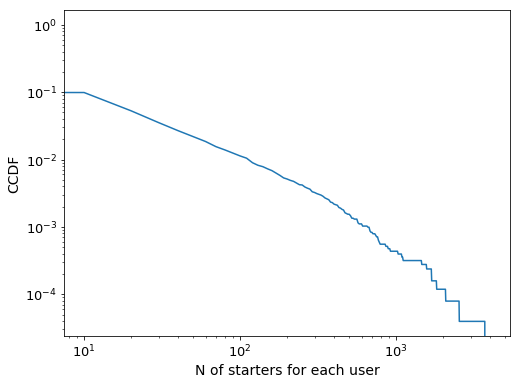

In [227]:
x, cdf, pdf = get_cdf_pdf(user_tweets_cnt, 0, 4000, 10)
plt.figure(figsize=(8, 6))
# user_tweets_cnt.hist(bins=50)
plt.plot(x, cdf)
# plt.title('Distribution of size of fake news ', fontsize=15)
plt.ylabel('CCDF', fontsize=14)
plt.xlabel('N of starters for each user', fontsize=14)
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.yscale("log")
plt.xscale("log")
plt.savefig('fig/distribution_starters.pdf', dpi=300)
plt.show()
plt.close()

In [240]:
len(user_tweets_cnt[user_tweets_cnt>20])

1285

In [245]:
len(user_tweets_cnt[user_tweets_cnt>20]) / len(user_tweets_cnt)

0.050836729042212286

In [244]:
user_tweets_cnt[user_tweets_cnt>20].sum() / user_tweets_cnt.sum()

0.6799510602728601